In [2]:
import pennylane as qml
from pennylane import numpy as np


import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=50)

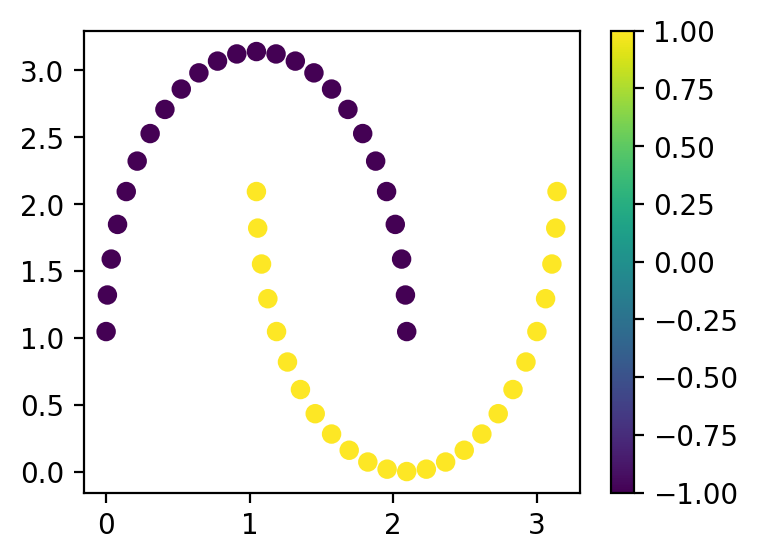

In [3]:
def normalize(x):
    """
    Переводит значения в интервал от 0 до pi
    """
    min_ = x.min()
    max_ = x.max()
    return np.pi * (x - min_) / (max_ - min_)

x[:, 0] = normalize(x[:, 0])
x[:, 1] = normalize(x[:, 1])
y = y * 2 - 1

plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=y)
plt.colorbar(cb)
plt.show()

In [4]:
dev = qml.device("default.qubit", 2)

def encoding(x1, x2):
    qml.RY(x1, wires=0)
    qml.RY(x2, wires=1)
    qml.RZ(x1, wires=0)
    qml.RZ(x2, wires=1)
    qml.CZ(wires=[0, 1])

In [5]:
def layer(theta):
    qml.Rot(theta[0, 0], theta[0, 1], theta[0, 2], wires=0)
    qml.Rot(theta[1, 0], theta[1, 1], theta[1, 2], wires=1)
    qml.CZ(wires=[0, 1])

In [6]:
@qml.qnode(dev)
def node(x1, x2, q):
    encoding(x1, x2)
    for q_ in q:
        layer(q_)

    return qml.expval(qml.PauliZ(0) @ qml.PauliY(1))

In [7]:
def apply_node(x, q):
    res = []

    for x_ in x:
        vqc_output = node(x_[0], x_[1], q[0])
        res.append(vqc_output)

    return res

In [52]:
print(len(apply_node(x,q)))

50


In [32]:

def cost(q, x, y):
    preds = np.array(apply_node(x, q))
    return np.square(np.subtract(y, preds)).mean()
    #return np.mean(np.square(preds - y))

In [27]:
def acc(q, x, y):
    preds = np.sign(apply_node(x, q))
    res = 0
    for p_, y_ in zip(preds, y):
        if np.abs(y_ - p_) <= 1e-2:
            res += 1

    return res / y.shape[0]

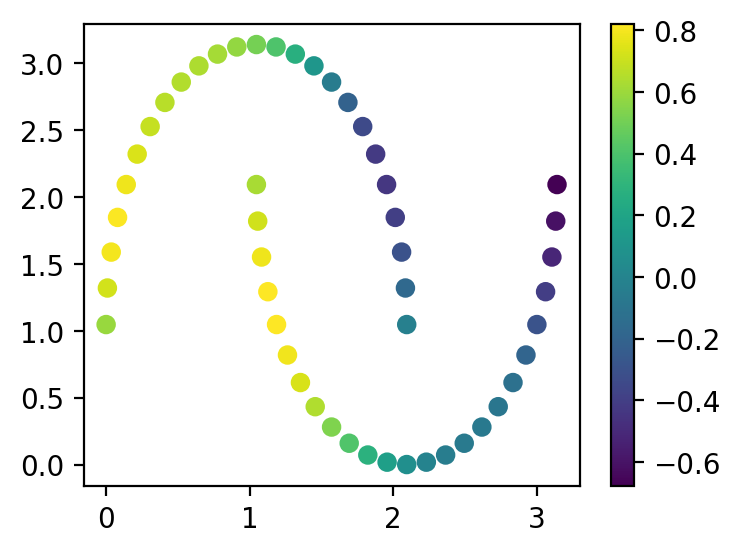

In [33]:
np.random.seed(42)
q = (np.random.uniform(-np.pi, np.pi, size=(4, 2, 3)), 0.0)
plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=apply_node(x, q))
plt.colorbar(cb)
plt.show()



In [38]:
print(q)

(tensor([[[-0.78828768,  2.83192151,  1.45766093],
         [ 0.61988954, -2.16129862, -2.16145018]],

        [[-2.77664256,  2.30075258,  0.63532436],
         [ 1.30735856, -3.01225646,  2.95253068]],

        [[ 2.08879872, -1.80742667, -1.99915269],
         [-1.98922813, -1.22998226,  0.15554925]],

        [[-0.42760206, -1.311746  ,  0.70279246],
         [-2.26512688, -1.30599369, -0.8396733 ]]], requires_grad=True), 0.0)


In [34]:
opt = qml.optimize.GradientDescentOptimizer(stepsize=0.05)
acc_ = []
cost_ = []
ii = []
for i in range(75):
    batch = np.random.randint(0, len(x), (50,))
    x_batch = x[batch, :]
    y_batch = y[batch]
    def a(k):
        return(cost(k, x_batch, y_batch))
  #  q, e = opt.step_and_cost(a, q)
    #print(q)
    #print("--------------------------------------------------------")
    #q = opt.step(lambda q_: cost(q_, x_batch, y_batch), q)
    q = opt.step(a, q)
    #print(q)
    #print("--------------------------------------------------------")
    if i % 5 == 0:
        ii.append(i)
        acc_.append(acc(q, x, y))        
        cost_.append(cost(q, x, y))
        #cost_.append(e)

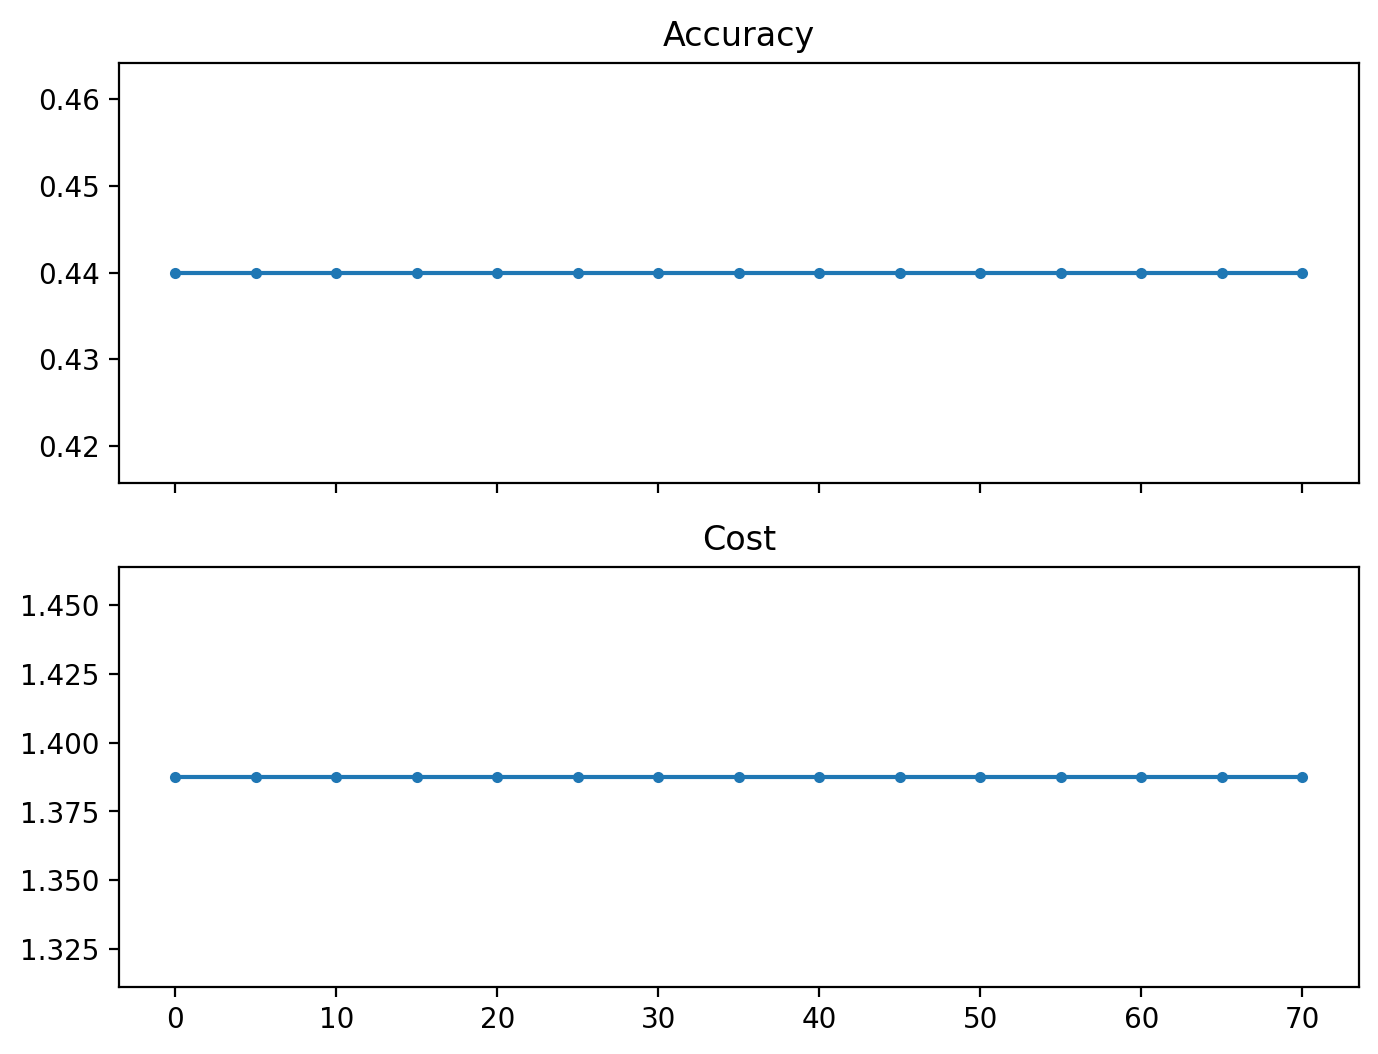

In [35]:
f, ax = plt.subplots(2, figsize=(8, 6), sharex=True)
ax[0].plot(ii, acc_, ".-")
ax[0].set_title("Accuracy")
ax[1].plot(ii, cost_, ".-")
ax[1].set_title("Cost")
plt.show()

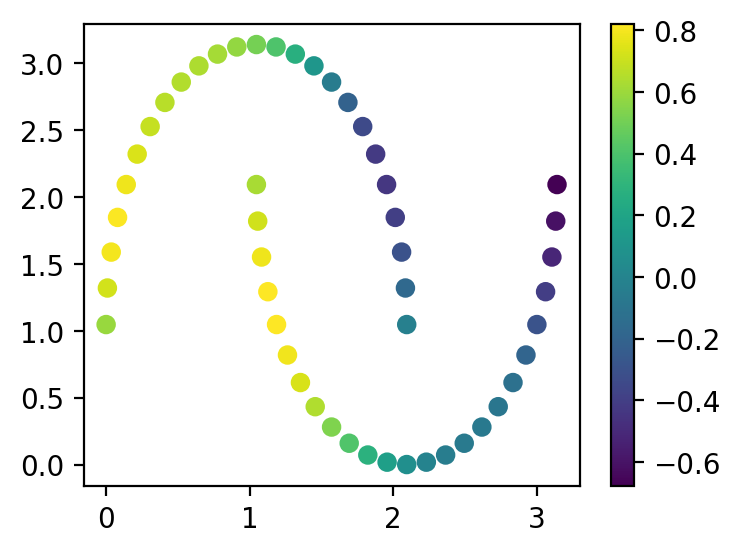

In [36]:
plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=apply_node(x, q))
plt.colorbar(cb)
plt.show()


In [37]:
print(q)

(tensor([[[-0.78828768,  2.83192151,  1.45766093],
         [ 0.61988954, -2.16129862, -2.16145018]],

        [[-2.77664256,  2.30075258,  0.63532436],
         [ 1.30735856, -3.01225646,  2.95253068]],

        [[ 2.08879872, -1.80742667, -1.99915269],
         [-1.98922813, -1.22998226,  0.15554925]],

        [[-0.42760206, -1.311746  ,  0.70279246],
         [-2.26512688, -1.30599369, -0.8396733 ]]], requires_grad=True), 0.0)
